# DTSA-5511 Week 4 Programming Assignment

The objective of this assignment is to use the [Natural Language Processing with Disaster Tweets](https://www.kaggle.com/competitions/nlp-getting-started/overview) Kaggle competition data to compare the performance of three different recurrent neural network (RNN) models for performing a text classification. The architectures I tried are the SimpleRNN, LSTM, and GRU models from the [Keras](https://keras.io/) package.

The dataset contains 7613 tweets with an average length of 15 words. Each tweet is labeled with a target of `1` or `0` (`1` indicating that the tweet is about a real disaster, and `0` indicating no disaster). The goal is to train models that can correctly separate disaster-related tweets from tweets that are not about disasters.

The challenge here is that the non-disaster-related tweets often contain language that might easily fool a model if keywords were taken in isolation (e.g., "Has an accident changed your life?" vs "Car accident on I-75..."). This requires the models to develop a sense of context, which RNNs are capable of doing in their hidden state vectors.

This notebook was run in a Google Collab environment. I based the Keras code on this post: https://machinelearningmastery.com/sequence-classification-lstm-recurrent-neural-networks-python-keras/.


## Import Kaggle Data

In [55]:
from google.colab import files

In [ ]:
files.upload()

In [57]:
!pwd

/content


In [58]:
!mkdir -p /root/.config/kaggle

In [59]:
!mv kaggle.json /root/.config/kaggle/

In [60]:
!chmod 600 /root/.config/kaggle/kaggle.json

In [61]:
!kaggle competitions download -c nlp-getting-started

nlp-getting-started.zip: Skipping, found more recently modified local copy (use --force to force download)


In [62]:
!unzip -q nlp-getting-started.zip

replace sample_submission.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace test.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
replace train.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: y


## EDA

In [111]:
import pandas as pd
import numpy as np
import itertools
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, LSTM, GRU, Dense, Dropout
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Let's view a snapshot of the training dataset. We see that each tweet (`text`) is labeled in the `target` column. For some tweets, a `keyword` and `location` are associated as well.

In [144]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')
train_df.head(20)



,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
5,8,NaN,NaN,#RockyFire Update => California Hwy. 20 closed...,1
6,10,NaN,NaN,#flood #disaster Heavy rain causes flash flood...,1
7,13,NaN,NaN,I'm on top of the hill and I can see a fire in...,1
8,14,NaN,NaN,There's an emergency evacuation happening now ...,1
9,15,NaN,NaN,I'm afraid that the tornado is coming to our a...,1


Number of tweets in the training set

In [65]:
len(train_df)

7613

Average tweet length from the training set

In [66]:
np.round(train_df['text'].apply(lambda x: len(x.split())).mean())

np.float64(15.0)

Minimum tweet length

In [67]:
train_df['text'].apply(lambda x: len(x.split())).min()

1

Maximum tweet length

In [68]:
MAX_SEQUENCE_LENGTH = train_df['text'].apply(lambda x: len(x.split())).max()
MAX_SEQUENCE_LENGTH

31

Distribution of tweet lengths

<Axes: >

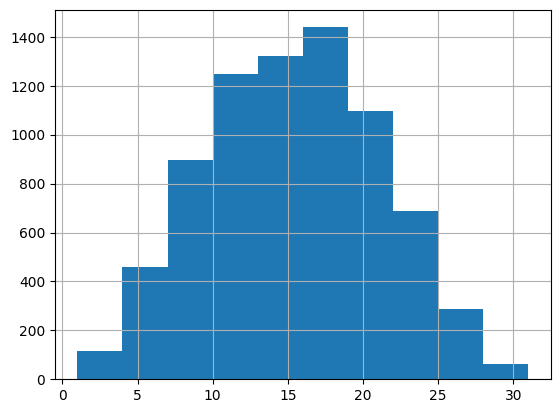

In [69]:
train_df['text'].apply(lambda x: len(x.split())).hist()

There are 221 unique values in the `keyword` column.

In [70]:
train_df['keyword'].value_counts()

,count
keyword,
fatalities,45
deluge,42
armageddon,42
damage,41
body%20bags,41
...,...
forest%20fire,19
epicentre,12
threat,11


The `location` column has 3,341 unique values.

In [71]:
train_df['location'].value_counts()

,count
location,
USA,104
New York,71
United States,50
London,45
Canada,29
...,...
"Silesia, Poland",1
"Hickville, USA",1
New York NYC,1


The distriution of `1` and `0` in the `target` column is slightly skewed toward `0` (no disaster). We'll have to make sure that the train and validation sets preserve this distribution.

In [72]:
train_df['target'].value_counts()

,count
target,
0,4342
1,3271


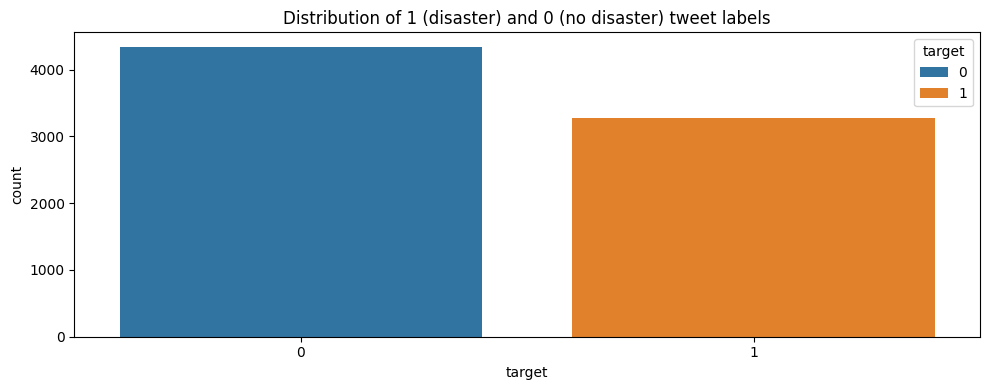

In [73]:
plt.figure(figsize=(10, 4))
sns.countplot(data=train_df, x="target", order=train_df['target'].value_counts().index, hue='target')
plt.title("Distribution of 1 (disaster) and 0 (no disaster) tweet labels")
plt.tight_layout()
plt.show()

## Data Cleaning

Let's look at the top 30 words in the `train_df.text` column. As you can see, these are dominated by [stop words](https://en.wikipedia.org/wiki/Stop_word#:~:text=Stop%20words%20are%20the%20words,because%20they%20are%20deemed%20insignificant).

In [145]:
# Split each text into words and stack them into a single pandas series
all_words_series = train_df['text'].str.split(expand=True).stack()

top_30_words = all_words_series.value_counts().head(30)

print("30 most common words in train_df['text'] before stop word removal:")
print(top_30_words)

30 most common words in train_df['text'] before stop word removal:
the      2575
a        1845
to       1805
in       1757
of       1722
and      1302
I        1197
for       820
is        814
on        773
-         763
you       632
The       552
my        549
with      508
that      492
at        485
by        469
it        433
from      372
be        371
was       363
have      353
are       345
this      335
like      318
&amp;     295
A         290
as        282
just      258
Name: count, dtype: int64


Let's use the `nltk` package to remove stop words from the `train_df.text` column.

In [146]:
stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    # Split the text into words
    words = text.split()
    # Remove stop words
    filtered_words = [word for word in words if word.lower() not in stop_words]
    # Join the words back into a string
    return " ".join(filtered_words)

# Apply stop word removal to the 'text' column in both train and test DataFrames
train_df['text'] = train_df['text'].apply(remove_stopwords)
test_df['text'] = test_df['text'].apply(remove_stopwords)


We see that the top words (tokens) are now quite different. I compared the model training with and without stop word removal, and I saw a slight improvement from removing stop words, so we will keep these "cleaned" versions of the datasets.

In [147]:
all_words_series = train_df['text'].str.split(expand=True).stack()

top_30_words = all_words_series.value_counts().head(30)

print("30 most common words in train_df['text'] after stop word removal:")
print(top_30_words)

30 most common words in train_df['text'] after stop word removal:
-             763
like          318
&amp;         295
??            214
via           208
get           183
fire          148
...           147
people        146
2             145
|             142
one           142
would         116
new           105
got           103
New            98
????           96
know           96
video          93
going          91
killed         89
California     89
still          88
burning        86
see            85
back           85
@YouTube       82
go             81
3              81
RT             80
Name: count, dtype: int64


## Import Pre-trained Embeddings

I decided to use [GloVe](https://nlp.stanford.edu/projects/glove/) pre-trained word embeddings as a foundation for training the RNN models (see https://keras.io/examples/nlp/pretrained_word_embeddings/). These are vectorizations of words (tokens) learned from a large corpus of text (Wikipedia and Gigaword data). I chose a dimension of 100 for the vectors as a tradeoff between depth of semantic relationships and model training efficiency.

In [77]:
!curl -L -O https://nlp.stanford.edu/data/wordvecs/glove.2024.wikigiga.100d.zip

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
  0   371    0     0    0     0      0      0 --:--:-- --:--:-- --:--:--     0
100  554M  100  554M    0     0  5243k      0  0:01:48  0:01:48 --:--:-- 5047k


In [78]:
!unzip glove.2024.wikigiga.100d.zip

Archive:  glove.2024.wikigiga.100d.zip
replace wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: y
  inflating: wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt  


`glove_dict` has the tokens as keys and their associated 100-dimensional vectors as values. Tokens can be words, parts of words, and also punctuation.

In [79]:
EMBEDDING_DIMENSION = 100
glove_file = 'wiki_giga_2024_100_MFT20_vectors_seed_2024_alpha_0.75_eta_0.05.050_combined.txt'
glove_dict = {}
num_lines_skipped = 0
with open(glove_file, 'r', encoding='utf-8') as f:
    total_number_lines = len(f.readlines())
    print(f"Total number of lines in the GloVe file before pruning: {total_number_lines}.")
with open(glove_file, 'r', encoding='utf-8') as f:
    for line in f:
        line_split_list = line.split()
        token = line_split_list[0]
        try:
            embedding = np.array(line_split_list[1:], dtype='float32')
            if len(embedding) == EMBEDDING_DIMENSION:
                glove_dict[token] = embedding
            else:
                num_lines_skipped += 1
        except ValueError:
            num_lines_skipped += 1
            continue

print(f"Total lines skipped from the original GloVe file: {num_lines_skipped}.")
first_3_items = dict(itertools.islice(glove_dict.items(), 3))
first_3_items

Total number of lines in the GloVe file before pruning: 1291147.
Total lines skipped from the original GloVe file: 3533.


{'the': array([ 0.306717, -0.32053 , -0.393647,  0.082826,  0.073522, -0.409154,
        -0.265564, -0.23694 , -0.305832,  0.74529 ,  0.214341,  0.276781,
        -0.152797, -0.127524,  0.119525,  0.640965, -0.175869,  0.160711,
         0.477978, -0.160939, -0.150093,  0.674601, -0.099565,  0.021882,
        -0.032771,  0.368641, -0.087019, -0.133326,  0.170143,  0.156934,
         0.677506, -0.099686,  0.392113,  0.373434, -5.736062,  0.413845,
         0.477368, -0.041697,  0.383109,  0.120152, -0.20947 ,  0.605104,
         0.236353,  0.151131, -0.508865,  0.671239, -0.300263, -0.267927,
         2.549487,  0.067177,  0.217224, -0.031316,  0.05231 ,  0.119321,
        -0.332154, -0.807904, -0.546453, -0.044392, -0.281657,  0.286647,
         0.325775, -0.02196 , -0.636903, -0.268063,  0.247956, -0.402493,
         0.276707, -0.275139,  0.201159,  0.082844,  0.591695, -0.017127,
        -0.092269,  0.392008,  0.078245, -0.049907,  0.235151,  0.457376,
        -0.111987, -0.05691 ,  

The `Tokenizer()` object from Keras is used to assign integers to each unique token in the `train_df.text` column.

In [80]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(train_df['text'])
word_index = tokenizer.word_index
VOCAB_SIZE = len(word_index) + 1 # Add one for keras padding token

print("Token: Index from disaster tweets")
for word, index in list(word_index.items())[:10]:
    print(f"{word}: {index}")

print(f"\nTotal vocabulary size is {VOCAB_SIZE}.")

Token: Index from disaster tweets
t: 1
co: 2
http: 3
https: 4
like: 5
amp: 6
fire: 7
get: 8
new: 9
via: 10

Total vocabulary size is 22653.


`embedding_matrix` is formed by placing vectors for tokens that exist in `glove_dict` into the row indexed by the integer in the `word_index` dictionary (from `Tokenizer()`). If a word from `word_index` is not in `glove_dict`, then the row at that index remains full of zeroes. Later, we will make adjustments to these embedding vectors as they are treated like weights modified through backpropagation.

In [81]:
embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIMENSION))

words_not_found = []
for word, index in word_index.items():
    embedding_vector = glove_dict.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector
    else:
        words_not_found.append(word)

print(f"Shape of embedding matrix: {embedding_matrix.shape}")
print(f"Number of tokens not found in the GloVe file: {len(words_not_found)}")

print(f"First 10 tokens not found: {words_not_found[:10]}")

Shape of embedding matrix: (22653, 100)
Number of tokens not found in the GloVe file: 9614
First 10 tokens not found: ["can't", '\x89û', "that's", 'gonna', '\x89ûò', "there's", "'the", "legionnaires'", 'prebreak', '16yr']


## Model Training

Because the tweets do not all have the same length, we need to pad them by 0 and give them a uniform length. The tweet vectors are placed into the rows of a matrix (`X`). Each non-zero element in the vectors is an integer representing a token (i.e. a row index) from `embedding_matrix`.

We also create a vector of the `target` values we'll call `y`.

In [82]:
# Convert tweets into sequences of integers (for embedding vector lookup)
sequences = tokenizer.texts_to_sequences(train_df['text'])

# Pad sequences so they are all the max length from the tweets
X = pad_sequences(sequences, maxlen=MAX_SEQUENCE_LENGTH)

# Define training label vector
y = np.array(train_df['target'])

print("Shape of data matrix (X):", X.shape)
print("Shape of label vector (y):", y.shape)

Shape of data matrix (X): (7613, 31)
Shape of label vector (y): (7613,)


In [83]:
X[0:5] # View the first 5 rows of the X matrix

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0, 4552,  764,  174,   66, 1520, 4553,   25],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,  106,    7,  144,  699, 6877, 6878, 1300],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0, 1652, 1521,
        6879, 6880, 6881, 1653,  168, 2059,  615, 1301, 1005],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,  732, 2826,   13, 4554, 1397,  168, 1301,   32],
       [   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
        

### Model 1

The first model we'll train is a "vanilla" RNN. The structure is embeddings -> RNN (with a hidden state vector length of 64) -> densely connected layer for classification (trained with 0.5 dropout to avoid overfitting the training data) -> densely connected binary output layer.

In [121]:
model_vanilla_RNN = Sequential([
        # Embedding layer, initialized with pre-trained GloVe weights
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBEDDING_DIMENSION,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=True,  # Allow the embeddings to be adjusted in backpropagation
            name='embedding_layer'
        ),
        SimpleRNN(64, name='simple_rnn_layer'),

        # Dropout layer for the classifier to prevent overfitting
        Dropout(0.5, name='dropout_layer'),

        # Final binary classifier
        Dense(1, activation='sigmoid', name='output_layer') # Custom name for the Dense layer
    ], name='vanilla_rnn_model')

model_vanilla_RNN.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_vanilla_RNN.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_vanilla_RNN.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "vanilla_rnn_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 31, 100)        │     2,265,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ simple_rnn_layer (SimpleRNN)    │ (None, 64)             │        10,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,275,925 (8.68 MB)

 Trainable params: 2,275,925 (8.68 MB)

 Non-trainable params: 0 (0.00 B)

We'll use the `ReduceLROnPlateau` method to dynamically reduce the learning rate when we approach a minimum in the loss landscape.

In [122]:
# Reduce the learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 patience=2,
                                 factor=0.2,
                                 min_lr=0.00001)

We'll also use the `ModelCheckpoint` callback to return the best model from the 10 epochs.

In [123]:
# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(filepath='best_model_vanilla_RNN.keras',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')

In [124]:
# Use stratify=y to maintain the same proportion 1 and 0 in target for validation set
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

EPOCHS_1 = 10
history_1 = model_vanilla_RNN.fit(
    X_train, y_train,
    epochs=EPOCHS_1,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, model_checkpoint],
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step - accuracy: 0.6129 - loss: 0.6846 - val_accuracy: 0.8037 - val_loss: 0.4311 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8143 - loss: 0.4357 - val_accuracy: 0.8194 - val_loss: 0.4199 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.8582 - loss: 0.3505 - val_accuracy: 0.8037 - val_loss: 0.4522 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 17ms/step - accuracy: 0.9049 - loss: 0.2566 - val_accuracy: 0.8214 - val_loss: 0.4812 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9445 - loss: 0.1573 - val_accuracy: 0.8168 - val_loss: 0.4695 - learning_rate: 2.0000e-04
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9593 - loss: 0.1270 - val_accuracy: 0.8096 - val_loss: 0.4961 - learning_rate: 2.0000e-04
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 3s 18ms/step - accuracy: 0.9605 - 

In [125]:
# Load the best saved model
best_vanilla_RNN_model = load_model('best_model_vanilla_RNN.keras')

# Evaluate the loaded model on the validation set
loss, accuracy = best_vanilla_RNN_model.evaluate(X_val, y_val, verbose=0)

print(f"Evaluation of the best saved vanilla RNN model on the validation set:")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.4f}")

Evaluation of the best saved vanilla RNN model on the validation set:
  Loss: 0.4199
  Accuracy: 0.8194


In [126]:
print(history_1.history.keys())

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss', 'learning_rate'])


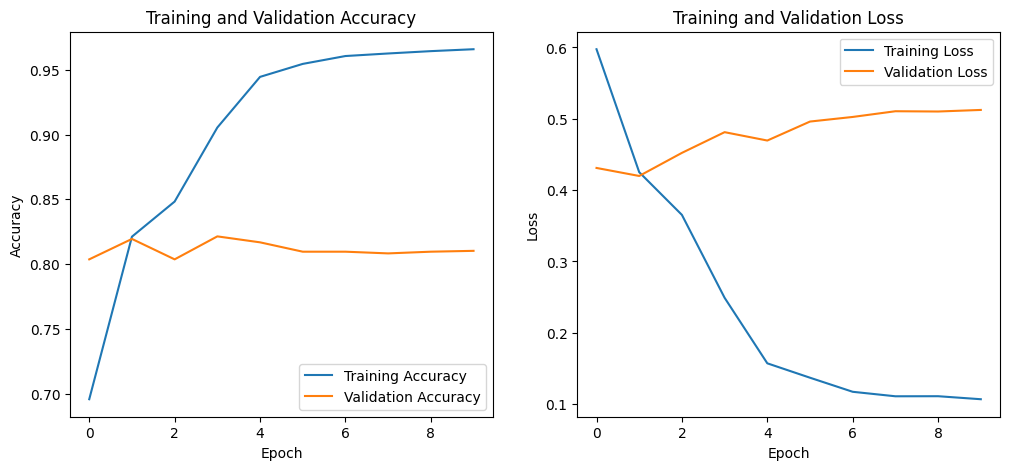

In [127]:
# Get the metrics from the history object
acc_1 = history_1.history['accuracy']
val_acc_1 = history_1.history['val_accuracy']
loss_1 = history_1.history['loss']
val_loss_1 = history_1.history['val_loss']

epochs_range = range(EPOCHS_1)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_1, label='Training Accuracy')
plt.plot(epochs_range, val_acc_1, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_1, label='Training Loss')
plt.plot(epochs_range, val_loss_1, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [128]:
# Make predictions on the validation set
y_pred_prob = best_vanilla_RNN_model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step
Precision: 0.8153
Recall: 0.7492
F1-score: 0.7809


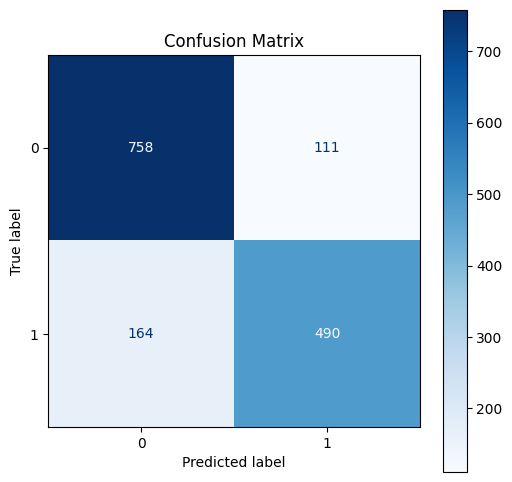

In [129]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

### Model 1 Results

The vanilla RNN results show a pattern of overfitting beyond the 3rd epoch. The training accuracy increases and the training loss decreases over the 10 epochs. However, the validation accuracy peaks around epoch 3 and then starts to decrease, while the validation loss increases steadily after epoch 2. This divergence between the training and validation curves indicates that the model is failing to generalize to unseen data.

The relatively low recall compared to precision suggests that the model is more cautious about predicting a disaster, resulting in a higher number of false negatives.

### Model 2

The second model is an LSTM (Long Short-Term Memory) network. The code is similar to the vanilla RNN, replacing the `SimpleRNN` layer with an `LSTM` layer that has 64 units. LSTMs have a complex internal structure, consisting of both a hidden state vector as well as "cell state" vector for retaining longer-term details.

In [130]:
model_LSTM = Sequential([
        # Embedding layer, initialized with pre-trained GloVe weights
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBEDDING_DIMENSION,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=True,  # Allow the embeddings to be adjusted in backpropagation
            name='embedding_layer'
        ),
        LSTM(64, name='LSTM_layer'),

        # Dropout layer for the classifier to prevent overfitting
        Dropout(0.5, name='dropout_layer'),

        # Final binary classifier
        Dense(1, activation='sigmoid', name='output_layer') # Custom name for the Dense layer
    ], name='LSTM_model')

model_LSTM.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_LSTM.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_LSTM.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "LSTM_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 31, 100)        │     2,265,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ LSTM_layer (LSTM)               │ (None, 64)             │        42,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,307,605 (8.80 MB)

 Trainable params: 2,307,605 (8.80 MB)

 Non-trainable params: 0 (0.00 B)

In [131]:
# Reduce the learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 patience=2,
                                 factor=0.2,
                                 min_lr=0.00001)

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(filepath='best_model_LSTM.keras',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')

EPOCHS_2 = 10
history_2 = model_LSTM.fit(
    X_train, y_train,
    epochs=EPOCHS_2,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, model_checkpoint], # Added callbacks
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 31ms/step - accuracy: 0.7109 - loss: 0.5550 - val_accuracy: 0.8247 - val_loss: 0.4142 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8345 - loss: 0.3826 - val_accuracy: 0.8247 - val_loss: 0.4114 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.8819 - loss: 0.2960 - val_accuracy: 0.8194 - val_loss: 0.4226 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9243 - loss: 0.2030 - val_accuracy: 0.8162 - val_loss: 0.4726 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9659 - loss: 0.1081 - val_accuracy: 0.8155 - val_loss: 0.5609 - learning_rate: 2.0000e-04
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.9696 - loss: 0.0939 - val_accuracy: 0.7984 - val_loss: 0.6137 - learning_rate: 2.0000e-04
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9764 - 

In [132]:
# Load the best saved model
best_LSTM_model = load_model('best_model_LSTM.keras')

# Evaluate the loaded model on the validation set
loss, accuracy = best_LSTM_model.evaluate(X_val, y_val, verbose=0)

print(f"Evaluation of the best saved LSTM model on the validation set:")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.4f}")

Evaluation of the best saved LSTM model on the validation set:
  Loss: 0.4114
  Accuracy: 0.8247


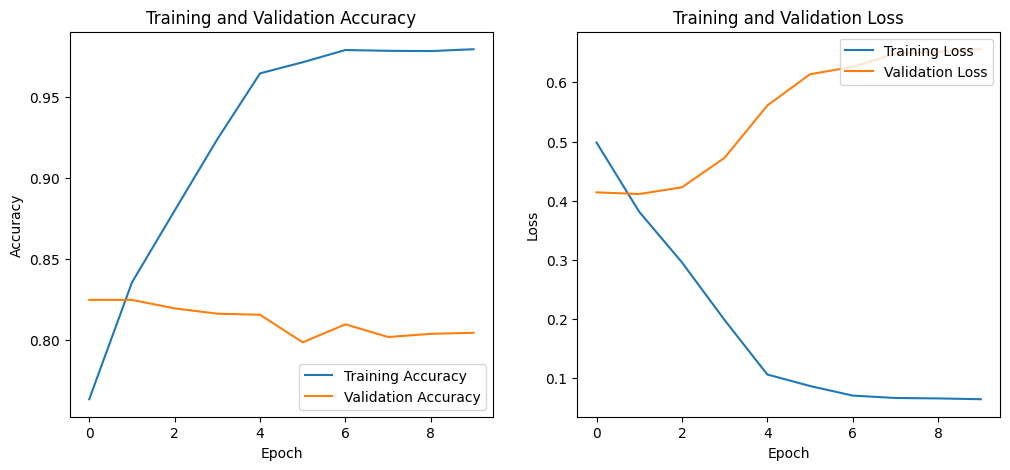

In [133]:
# Get the metrics from the history object
acc_2 = history_2.history['accuracy']
val_acc_2 = history_2.history['val_accuracy']
loss_2 = history_2.history['loss']
val_loss_2 = history_2.history['val_loss']

epochs_range = range(EPOCHS_2)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_2, label='Training Accuracy')
plt.plot(epochs_range, val_acc_2, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_2, label='Training Loss')
plt.plot(epochs_range, val_loss_2, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [134]:
# Make predictions on the validation set
y_pred_prob = best_LSTM_model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step
Precision: 0.8057
Recall: 0.7798
F1-score: 0.7925


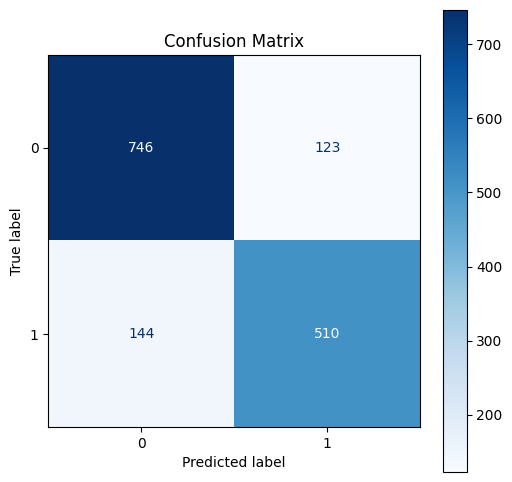

In [135]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

### Model 2 Results

The LSTM model also shows patterns of overfitting, similar to the vanilla RNN.

It's a little surprising that the LSTM model's performance is not much of an improvement over the simpler vanilla RNN, since the complexity of the model with its "forget" gates in theory should reduce the vanishing gradient problem. The mediocre performance could be attributed to the LSTM's greater number of parameters, which require more training data to learn effectively and can lead to overfitting on smaller datasets or shorter sequences like these tweets. It's possible that these tweets are so short, there is not enough information in the sequence to cause the gradient to "vanish", so there might be only a disadvantage in using the more complex LSTM architecture.

### Model 3

The third model is a Gated Recurrent Unit (GRU) network. This replaces the `LSTM` layer with a `GRU` layer, which also has 64 units. GRUs have fewer gates than LSTMs, making them simpler and computationally less expensive.

In [136]:
model_GRU = Sequential([
        # Embedding layer, initialized with pre-trained GloVe weights
        Embedding(
            input_dim=VOCAB_SIZE,
            output_dim=EMBEDDING_DIMENSION,
            weights=[embedding_matrix],
            input_length=MAX_SEQUENCE_LENGTH,
            trainable=True,  # Allow the embeddings to be adjusted in backpropagation
            name='embedding_layer'
        ),
        GRU(64, name='GRU_layer'),

        # Dropout layer for the classifier to prevent overfitting
        Dropout(0.5, name='dropout_layer'),

        # Final binary classifier
        Dense(1, activation='sigmoid', name='output_layer') # Custom name for the Dense layer
    ], name='GRU_model')

model_GRU.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

model_GRU.build(input_shape=(None, MAX_SEQUENCE_LENGTH))
model_GRU.summary()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "GRU_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_layer (Embedding)     │ (None, 31, 100)        │     2,265,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ GRU_layer (GRU)                 │ (None, 64)             │        31,872 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_layer (Dropout)         │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            65 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,297,237 (8.76 MB)

 Trainable params: 2,297,237 (8.76 MB)

 Non-trainable params: 0 (0.00 B)

In [138]:
# Reduce the learning rate when validation loss plateaus
lr_scheduler = ReduceLROnPlateau(monitor='val_loss',
                                 patience=2,
                                 factor=0.2,
                                 min_lr=0.00001)

# Save the best model based on validation loss
model_checkpoint = ModelCheckpoint(filepath='best_model_GRU.keras',
                                   save_best_only=True,
                                   monitor='val_loss',
                                   mode='min')

EPOCHS_3 = 10
history_3 = model_GRU.fit(
    X_train, y_train,
    epochs=EPOCHS_3,
    batch_size=32,
    validation_data=(X_val, y_val),
    callbacks=[lr_scheduler, model_checkpoint], # Added callbacks
    verbose=1
)

Epoch 1/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 9s 31ms/step - accuracy: 0.6636 - loss: 0.6119 - val_accuracy: 0.8181 - val_loss: 0.4084 - learning_rate: 0.0010
Epoch 2/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 29ms/step - accuracy: 0.8334 - loss: 0.3949 - val_accuracy: 0.8299 - val_loss: 0.4011 - learning_rate: 0.0010
Epoch 3/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 31ms/step - accuracy: 0.8913 - loss: 0.2827 - val_accuracy: 0.8267 - val_loss: 0.4219 - learning_rate: 0.0010
Epoch 4/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 8s 43ms/step - accuracy: 0.9345 - loss: 0.1751 - val_accuracy: 0.8122 - val_loss: 0.5134 - learning_rate: 0.0010
Epoch 5/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 26ms/step - accuracy: 0.9739 - loss: 0.0736 - val_accuracy: 0.8102 - val_loss: 0.5469 - learning_rate: 2.0000e-04
Epoch 6/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 5s 28ms/step - accuracy: 0.9830 - loss: 0.0621 - val_accuracy: 0.8102 - val_loss: 0.6012 - learning_rate: 2.0000e-04
Epoch 7/10
191/191 ━━━━━━━━━━━━━━━━━━━━ 6s 30ms/step - accuracy: 0.9850 - 

In [139]:
# Load the best saved model
best_GRU_model = load_model('best_model_GRU.keras')

# Evaluate the loaded model on the validation set
loss, accuracy = best_GRU_model.evaluate(X_val, y_val, verbose=0)

print(f"Evaluation of the best saved GRU model on the validation set:")
print(f"  Loss: {loss:.4f}")
print(f"  Accuracy: {accuracy:.4f}")

Evaluation of the best saved GRU model on the validation set:
  Loss: 0.4011
  Accuracy: 0.8299


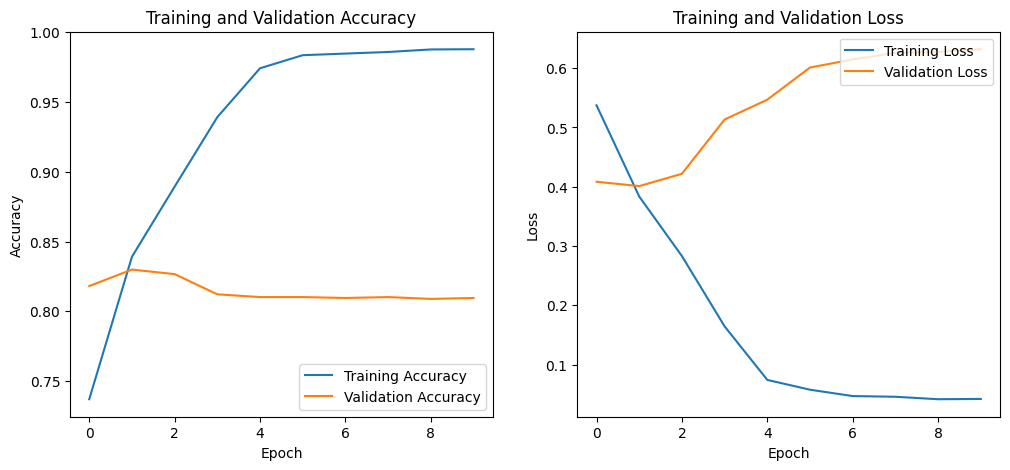

In [140]:
# Get the metrics from the history object
acc_3 = history_3.history['accuracy']
val_acc_3 = history_3.history['val_accuracy']
loss_3 = history_3.history['loss']
val_loss_3 = history_3.history['val_loss']

epochs_range = range(EPOCHS_3)

plt.figure(figsize=(12, 5))

# Plot 1: Accuracy
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc_3, label='Training Accuracy')
plt.plot(epochs_range, val_acc_3, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

# Plot 2: Loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss_3, label='Training Loss')
plt.plot(epochs_range, val_loss_3, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')

plt.show()

In [141]:
# Make predictions on the validation set
y_pred_prob = best_GRU_model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int) # Convert probabilities to binary predictions

# Calculate precision, recall, and F1-score
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-score: {f1:.4f}")

48/48 ━━━━━━━━━━━━━━━━━━━━ 1s 14ms/step
Precision: 0.8411
Recall: 0.7446
F1-score: 0.7899


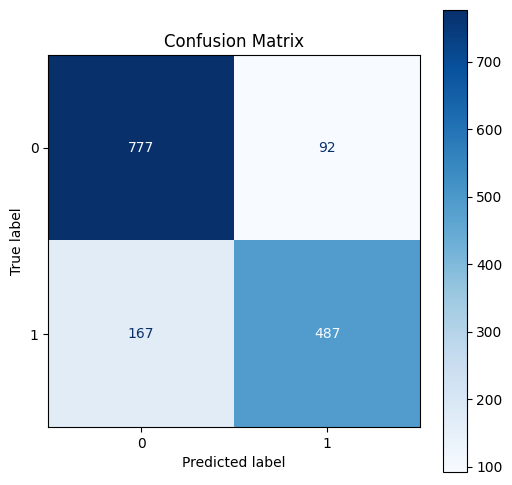

In [142]:
# Calculate the confusion matrix
cm = confusion_matrix(y_val, y_pred)

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1])

fig, ax = plt.subplots(figsize=(6, 6))
disp.plot(cmap=plt.cm.Blues, ax=ax)
plt.title('Confusion Matrix')
plt.show()

### Model 3 Results

The GRU model, like other models, also shows signs of overfitting. Comparing the GRU's performance to the LSTM, the GRU model achieved a slightly lower F1-score on the validation set compared to the LSTM. The GRU also showed a lower recall than the LSTM, meaning it was slightly worse at identifying actual disaster tweets. However, the GRU had a higher precision (meaning it was more conservative in assigning positives). Compared to the vanilla RNN and LSTM, the GRU performed slightly better in terms of accuracy. This could be due to the GRU's mix of gated architecture (improving over the vanilla RNN) but not so complex as the LSTM's architecture (better suited for a small dataset such as this one).

## Test Set Submission

In [143]:
# Get the text from the test DataFrame
test_texts = test_df['text']

# Use the same tokenizer to convert text to sequences of integers
test_sequences = tokenizer.texts_to_sequences(test_texts)

# Use the same padding length to make sequences uniform
X_test = pad_sequences(test_sequences, maxlen=MAX_SEQUENCE_LENGTH)

print(f"Shape of preprocessed test data (X_test): {X_test.shape}")


predictions = best_GRU_model.predict(X_test)
predicted_labels = (predictions > 0.5).astype(int)
predicted_labels = predicted_labels.flatten()

print(f"Sample predictions (first 5): {predicted_labels[:5]}")

submission_df = pd.DataFrame({
    'id': test_df['id'],
    'target': predicted_labels
})

submission_df.to_csv('submission.csv', index=False)

print(submission_df.head())

Shape of preprocessed test data (X_test): (3263, 31)
102/102 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step
Sample predictions (first 5): [1 1 1 1 1]
   id  target
0   0       1
1   2       1
2   3       1
3   9       1
4  11       1


## Conclusion

In this notebook, I compared the performance of three RNN models (vanilla RNN, LSTM, and GRU) for classifying disaster tweets.

All models showed signs of overfitting.

The GRU model performed best on the validation set, and for this reason I used that model to run inference against the test dataset. My best public score from Kaggle was ~.81. Obviously, there is much room for improvement.

I also experimented with increasing the hidden state size from 64 to 128 on the models, but this did not significantly improve results and sometimes made them slightly worse. To improve the models, techniques like bidirectional RNNs and more text preprocessing (stemming, lemmatization) would be worth pursuing.